In [1]:
# Import the required libraries
import torch
import torchvision.datasets as datasets
import torchvision
from torch.utils.data import Dataset, DataLoader, random_split
import torch.utils.data
from torchvision import transforms
from torch.nn.functional import interpolate
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
from PIL import Image

import math
import numpy as np
import pandas as pd

import os
from natsort import natsorted
import random
import pickle
from tqdm import tqdm

In [2]:
# Code to upload dataset to google colab
try:
    from google.colab import drive
    drive.mount('/content/drive')

    import zipfile

    path_to_zip_file = 'drive/MyDrive/data.zip'
    directory_to_extract_to = 'VISCHEMA_PLUS/'
    with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
        zip_ref.extractall(directory_to_extract_to)

    !cp "drive/MyDrive/viscplus_train.csv" "VISCHEMA_PLUS/"
    !cp "drive/MyDrive/viscplus_val.csv" "VISCHEMA_PLUS/"
except:
    print("not in colab")

not in colab


In [3]:
train_csv = pd.read_csv(f"VISCHEMA_PLUS/viscplus_train.csv", header = None)
print(len(train_csv))

print(len(train_csv[0:10]))
print(train_csv[0].values.tolist()[0:10])

1280
10
['sun_bqhdmnfpgbhtjemq.jpg', 'sun_brvopxqzbbmiggcc.jpg', 'sun_bykwtyvknquxsqzc.jpg', 'sun_bywhnbwhctljokav.jpg', 'sun_bcyqhmsuncrhyodx.jpg', 'sun_bglqunwuycxydmyu.jpg', 'sun_bjqxowluzxgdvssb.jpg', 'sun_brfossphjulspavp.jpg', 'sun_bmoouvnnsnxypsla.jpg', 'sun_brrpdracygynlgwk.jpg']


In [4]:
# Create datasets and dataloaders
class VISCHEMA_PLUS(Dataset):
    def __init__(self, dataset_dir = 'VISCHEMA_PLUS/', image_dir = 'images/', label_dir = 'vms/', train = True, transform = None, limit_length=False):
        
        if train:
            train_csv = pd.read_csv(f"{dataset_dir}viscplus_train.csv", header = None)
            if limit_length:
              all_images = train_csv[0].values.tolist()[0:10]
            else:
              all_images = train_csv[0].values.tolist()
        else:
            val_csv = pd.read_csv(f"{dataset_dir}viscplus_val.csv" , header = None)
            if limit_length:
              all_images = val_csv[0].values.tolist()[0:10]
            else:
              all_images = val_csv[0].values.tolist()
            
        self.transform = transform
        
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.dataset_dir = dataset_dir
        
        self.all_images = natsorted(all_images)
        
    def __len__(self):
        return len(self.all_images)

    def __getitem__(self, idx):    
        convert_tensor = transforms.ToTensor()
        
        image = Image.open(f"{self.dataset_dir}{self.image_dir}{self.all_images[idx]}").convert("RGB")
        image = convert_tensor(image)

        label = Image.open(f"{self.dataset_dir}{self.label_dir}{self.all_images[idx]}").convert("RGB")
        label = convert_tensor(label)
        
        if self.transform != None:
            image = self.transform(image)
            label = self.transform(label)
            
        return image, label



batch_size = 4
limit_length = 0
image_size = 64

image_transforms = transforms.Compose([
    transforms.Resize(image_size),
    transforms.Normalize(0.5,0.5)
])

train_dataset = VISCHEMA_PLUS(transform = image_transforms, train=True, limit_length=limit_length)
val_dataset   = VISCHEMA_PLUS(transform = image_transforms, train=False, limit_length=limit_length)

train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle=True)
val_loader   = DataLoader(dataset = val_dataset,   batch_size = batch_size, shuffle=True)

print(f'{len(train_dataset)} Items in Train dataset')
print(f'{len(val_dataset)}  Items in Validation dataset')

1280 Items in Train dataset
320  Items in Validation dataset


c:\Users\bluep\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


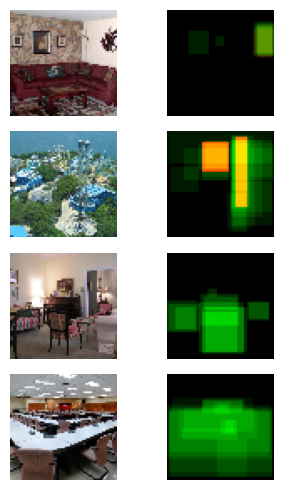

In [5]:
# Examine some image label pairs
import matplotlib.pyplot as plt

figure = plt.figure(figsize=(5,5))
cols, rows = 3, 4
for i in range(rows):
    
    images, labels = next(iter(train_loader))
    
    # The image
    figure.add_subplot(rows,cols, cols*i+1)
    plt.axis("off")
    plt.imshow((images[0].squeeze().permute(1, 2, 0) +1 )/2 )
    
    # The Label
    figure.add_subplot(rows,cols, cols*i+2)
    plt.axis("off")
    plt.imshow((labels[0].squeeze().permute(1, 2, 0) +1 )/2)
    
plt.tight_layout()
plt.show()

In [6]:
class Diffusion:
    def __init__(self, noise_steps=1000, beta_start=1e-4, beta_end=0.02, img_size=32):
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.img_size = img_size
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.beta = self.prepare_noise_schedule().to(self.device)
        self.alpha = 1. - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)

    def prepare_noise_schedule(self):
        return torch.linspace(self.beta_start, self.beta_end, self.noise_steps)

    def noise_images(self, x, t):
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t])[:, None, None, None]
        Ɛ = torch.randn_like(x)
        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * Ɛ, Ɛ

    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.noise_steps, size=(n,))

    def sample(self, model, n):
        model.eval()
        with torch.no_grad():
            images, labels = next(iter(val_loader))
            images, labels = images[0:n].to(self.device), labels[0:n].to(self.device)
            x = torch.randn((n, 3, self.img_size, self.img_size)).to(self.device)

            for i in tqdm(reversed(range(1, self.noise_steps)), position=0):
                t = (torch.ones(n) * i).long().to(self.device)
                predicted_noise = model(torch.cat((images,x),1), t)
                alpha = self.alpha[t][:, None, None, None]
                alpha_hat = self.alpha_hat[t][:, None, None, None]
                beta = self.beta[t][:, None, None, None]
                if i > 1:
                    noise = torch.randn_like(images)
                else:
                    noise = torch.zeros_like(images)
                x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
        model.train()
        x = (x.clamp(-1, 1) + 1) / 2
        x = (x * 255).type(torch.uint8)
        return x


In [7]:
class SelfAttention(nn.Module):
    def __init__(self, channels):
        super(SelfAttention, self).__init__()
        self.channels = channels        
        self.mha = nn.MultiheadAttention(channels, 4, batch_first=True)
        self.ln = nn.LayerNorm([channels])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([channels]),
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels),
        )

    def forward(self, x):
        size = x.shape[-1]
        x = x.view(-1, self.channels, size * size).swapaxes(1, 2)
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        attention_value = self.ff_self(attention_value) + attention_value
        return attention_value.swapaxes(2, 1).view(-1, self.channels, size, size)


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super().__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, mid_channels),
            nn.GELU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_channels),
        )

    def forward(self, x):
        if self.residual:
            return F.gelu(x + self.double_conv(x))
        else:
            return self.double_conv(x)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, t):
        try:
            x2 = self.maxpool_conv(x)
            emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x2.shape[-2], x2.shape[-1])
            return x2 + emb
        except:
            print(x.size())
            x = self.maxpool_conv(x)
            print(x.size())
            emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
            print(emb.size())
            return x + emb

class Up(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()

        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.conv = nn.Sequential(
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels, in_channels // 2),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, skip_x, t):
        x = self.up(x)
        x = torch.cat([skip_x, x], dim=1)
        x = self.conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb


class UNet(nn.Module):
    def __init__(self, c_in=6, c_out=3, time_dim=256, remove_deep_conv=False):
        super().__init__()
        self.time_dim = time_dim
        self.remove_deep_conv = remove_deep_conv
        self.inc = DoubleConv(c_in, 64)
        self.down1 = Down(64, 128)
        self.sa1 = SelfAttention(128)
        self.down2 = Down(128, 256)
        self.sa2 = SelfAttention(256)
        self.down3 = Down(256, 256)
        self.sa3 = SelfAttention(256)


        if remove_deep_conv:
            self.bot1 = DoubleConv(256, 256)
            self.bot3 = DoubleConv(256, 256)
        else:
            self.bot1 = DoubleConv(256, 512)
            self.bot2 = DoubleConv(512, 512)
            self.bot3 = DoubleConv(512, 256)

        self.up1 = Up(512, 128)
        self.sa4 = SelfAttention(128)
        self.up2 = Up(256, 64)
        self.sa5 = SelfAttention(64)
        self.up3 = Up(128, 64)
        self.sa6 = SelfAttention(64)
        self.outc = nn.Conv2d(64, c_out, kernel_size=1)

    def pos_encoding(self, t, channels):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        inv_freq = 1.0 / (
            10000
            ** (torch.arange(0, channels, 2, device = device).float() / channels)
        )
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc

    def unet_forwad(self, x, t):
        x1 = self.inc(x)
        x2 = self.down1(x1, t)
        x2 = self.sa1(x2)
        x3 = self.down2(x2, t)
        x3 = self.sa2(x3)
        x4 = self.down3(x3, t)
        x4 = self.sa3(x4)

        x4 = self.bot1(x4)
        if not self.remove_deep_conv:
            x4 = self.bot2(x4)
        x4 = self.bot3(x4)

        x = self.up1(x4, x3, t)
        x = self.sa4(x)
        x = self.up2(x, x2, t)
        x = self.sa5(x)
        x = self.up3(x, x1, t)
        x = self.sa6(x)
        output = self.outc(x)
        return output
    
    def forward(self, x, t):
        t = t.unsqueeze(-1)
        t = self.pos_encoding(t, self.time_dim)
        return self.unet_forwad(x, t)

In [8]:
def save_images(images, path, **kwargs):
    grid = torchvision.utils.make_grid(images, **kwargs)
    ndarr = grid.permute(1, 2, 0).to('cpu').numpy()
    im = Image.fromarray(ndarr)
    im.save(path)

In [11]:
def train(run_name):
    # Saved images and model directories
    for path in [f"models/{run_name}", f"results/{run_name}"]:
        exists = os.path.exists(path)
        if not exists:
            os.makedirs(path)

    # Set up our training environment
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = UNet().to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
    mse = nn.MSELoss()
    diffusion = Diffusion(img_size = image_size)
    l = len(train_loader)

    train_losses = []
    val_losses = []


    num_epochs = 600
    
    for epoch in range(num_epochs):
        total_train_loss = 0
        total_val_loss = 0
        print(f"Epoch: {epoch}")
        
        # Train Generator
        model.train()
        pbar = tqdm(train_loader)
        for i, (images, labels) in enumerate(pbar):
            images, labels = images.to(device), labels.to(device)    

            t = diffusion.sample_timesteps(labels.shape[0]).to(device)
            x_t, noise = diffusion.noise_images(labels, t)
            predicted_noise = model(torch.cat((images, x_t), 1), t)
            loss = mse(noise, predicted_noise)
            total_train_loss += loss.item() * batch_size

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item() * batch_size
            pbar.set_postfix(Train_Loss = total_train_loss)
            
        # Clear memory
        del images, labels
        torch.cuda.empty_cache() 

        # Validate Generator
        model.eval()
        with torch.no_grad():
            pbar = tqdm(val_loader)
            for i, (images, labels) in enumerate(pbar):

                images,labels = images.to(device), labels.to(device)
                
                t = diffusion.sample_timesteps(labels.shape[0]).to(device)
                x_t, noise = diffusion.noise_images(labels, t)
                predicted_noise = model(torch.cat((images, x_t), 1), t)
                loss = mse(noise, predicted_noise)
                total_val_loss += loss.item() * batch_size

                pbar.set_postfix(Val_loss = total_val_loss)

        # Save losses
        train_losses.append(total_train_loss/ len(train_loader))
        val_losses.append(total_val_loss / len(val_loader))

        # Save sample images every 20 epochs
        if epoch % 20 == 0:
            sampled_images = diffusion.sample(model, n=batch_size)
            save_images(sampled_images, os.path.join("results",run_name ,f"{epoch}.jpg"))
            torch.save(model.state_dict(), os.path.join("models",run_name, f"{epoch}.pt"))

        # Clear memory
        del images, labels 
        torch.cuda.empty_cache()

    print(f"Graph of {run_name}")
    plt.plot(range(len(train_losses)),train_losses,'r', label='Training Losses')
    plt.plot(range(len(val_losses)),val_losses,'g', label='Validation Losses')
    plt.legend(loc = "upper right")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

Epoch: 0


100%|██████████| 80/80 [00:08<00:00,  9.62it/s, Val_loss=21.2]
999it [00:36, 27.38it/s]


Epoch: 1


100%|██████████| 80/80 [00:08<00:00,  9.69it/s, Val_loss=11.9]


Epoch: 2


100%|██████████| 80/80 [00:08<00:00,  9.78it/s, Val_loss=10.1]


Epoch: 3


100%|██████████| 80/80 [00:08<00:00,  9.95it/s, Val_loss=6.78] 


Epoch: 4


100%|██████████| 80/80 [00:08<00:00,  9.98it/s, Val_loss=6.28] 


Epoch: 5


100%|██████████| 80/80 [00:08<00:00,  9.86it/s, Val_loss=7.28] 


Epoch: 6


100%|██████████| 80/80 [00:07<00:00, 10.18it/s, Val_loss=5.49]


Epoch: 7


100%|██████████| 80/80 [00:07<00:00, 10.13it/s, Val_loss=6.84] 


Epoch: 8


100%|██████████| 80/80 [00:07<00:00, 10.44it/s, Val_loss=4.71] 


Epoch: 9


100%|██████████| 80/80 [00:07<00:00, 10.28it/s, Val_loss=6.11] 


Epoch: 10


100%|██████████| 80/80 [00:07<00:00, 10.25it/s, Val_loss=6.89] 


Epoch: 11


100%|██████████| 80/80 [00:07<00:00, 10.34it/s, Val_loss=4.7]  


Epoch: 12


100%|██████████| 80/80 [00:07<00:00, 10.33it/s, Val_loss=4.64] 


Epoch: 13


100%|██████████| 80/80 [00:07<00:00, 10.25it/s, Val_loss=3.35] 


Epoch: 14


100%|██████████| 80/80 [00:07<00:00, 10.28it/s, Val_loss=4.33] 


Epoch: 15


100%|██████████| 80/80 [00:07<00:00, 10.18it/s, Val_loss=4.37]


Epoch: 16


100%|██████████| 80/80 [00:07<00:00, 10.21it/s, Val_loss=2.75] 


Epoch: 17


100%|██████████| 80/80 [00:07<00:00, 10.18it/s, Val_loss=4]    


Epoch: 18


100%|██████████| 80/80 [00:07<00:00, 10.22it/s, Val_loss=5.06] 


Epoch: 19


100%|██████████| 80/80 [00:07<00:00, 10.21it/s, Val_loss=3.41] 


Epoch: 20


100%|██████████| 80/80 [00:07<00:00, 10.21it/s, Val_loss=4.07] 
999it [00:33, 30.25it/s]


Epoch: 21


100%|██████████| 80/80 [00:07<00:00, 10.32it/s, Val_loss=3.72] 


Epoch: 22


100%|██████████| 80/80 [00:07<00:00, 10.24it/s, Val_loss=3.24] 


Epoch: 23


100%|██████████| 80/80 [00:07<00:00, 10.31it/s, Val_loss=2.91] 


Epoch: 24


100%|██████████| 80/80 [00:07<00:00, 10.34it/s, Val_loss=3.19] 


Epoch: 25


100%|██████████| 80/80 [00:07<00:00, 10.32it/s, Val_loss=3.26] 


Epoch: 26


100%|██████████| 80/80 [00:07<00:00, 10.24it/s, Val_loss=3.32] 


Epoch: 27


100%|██████████| 80/80 [00:07<00:00, 10.25it/s, Val_loss=2.78] 


Epoch: 28


100%|██████████| 80/80 [00:07<00:00, 10.23it/s, Val_loss=2.99]  


Epoch: 29


100%|██████████| 80/80 [00:07<00:00, 10.36it/s, Val_loss=3.52] 


Epoch: 30


100%|██████████| 80/80 [00:07<00:00, 10.38it/s, Val_loss=3.59] 


Epoch: 31


100%|██████████| 80/80 [00:07<00:00, 10.50it/s, Val_loss=2.78] 


Epoch: 32


100%|██████████| 80/80 [00:07<00:00, 10.38it/s, Val_loss=2.81] 


Epoch: 33


100%|██████████| 80/80 [00:07<00:00, 10.40it/s, Val_loss=2.56] 


Epoch: 34


100%|██████████| 80/80 [00:07<00:00, 10.37it/s, Val_loss=2.37] 


Epoch: 35


100%|██████████| 80/80 [00:07<00:00, 10.27it/s, Val_loss=2.74] 


Epoch: 36


100%|██████████| 80/80 [00:07<00:00, 10.33it/s, Val_loss=3.9]  


Epoch: 37


100%|██████████| 80/80 [00:07<00:00, 10.18it/s, Val_loss=2.19] 


Epoch: 38


100%|██████████| 80/80 [00:07<00:00, 10.39it/s, Val_loss=3.11] 


Epoch: 39


100%|██████████| 80/80 [00:07<00:00, 10.46it/s, Val_loss=2.15] 


Epoch: 40


100%|██████████| 80/80 [00:07<00:00, 10.40it/s, Val_loss=4.58] 
999it [00:33, 29.84it/s]


Epoch: 41


100%|██████████| 80/80 [00:07<00:00, 10.24it/s, Val_loss=2.69]  


Epoch: 42


100%|██████████| 80/80 [00:07<00:00, 10.33it/s, Val_loss=2.92]  


Epoch: 43


100%|██████████| 80/80 [00:07<00:00, 10.33it/s, Val_loss=2.16] 


Epoch: 44


100%|██████████| 80/80 [00:07<00:00, 10.36it/s, Val_loss=2.51]  


Epoch: 45


100%|██████████| 80/80 [00:07<00:00, 10.38it/s, Val_loss=2.68] 


Epoch: 46


100%|██████████| 80/80 [00:07<00:00, 10.36it/s, Val_loss=2.24]  


Epoch: 47


100%|██████████| 80/80 [00:07<00:00, 10.43it/s, Val_loss=2.26] 


Epoch: 48


100%|██████████| 80/80 [00:07<00:00, 10.29it/s, Val_loss=2.43] 


Epoch: 49


100%|██████████| 80/80 [00:07<00:00, 10.26it/s, Val_loss=2.25] 


Epoch: 50


100%|██████████| 80/80 [00:07<00:00, 10.21it/s, Val_loss=2.35] 


Epoch: 51


100%|██████████| 80/80 [00:07<00:00, 10.38it/s, Val_loss=3.4]  


Epoch: 52


100%|██████████| 80/80 [00:07<00:00, 10.34it/s, Val_loss=2.94] 


Epoch: 53


100%|██████████| 80/80 [00:07<00:00, 10.44it/s, Val_loss=1.91]  


Epoch: 54


100%|██████████| 80/80 [00:07<00:00, 10.38it/s, Val_loss=1.86] 


Epoch: 55


100%|██████████| 80/80 [00:07<00:00, 10.32it/s, Val_loss=2.37] 


Epoch: 56


100%|██████████| 80/80 [00:07<00:00, 10.30it/s, Val_loss=1.86] 


Epoch: 57


100%|██████████| 80/80 [00:07<00:00, 10.22it/s, Val_loss=2.24] 


Epoch: 58


100%|██████████| 80/80 [00:07<00:00, 10.23it/s, Val_loss=2.2]  


Epoch: 59


100%|██████████| 80/80 [00:07<00:00, 10.39it/s, Val_loss=2.35] 


Epoch: 60


100%|██████████| 80/80 [00:07<00:00, 10.24it/s, Val_loss=1.86] 
999it [00:33, 29.93it/s]


Epoch: 61


100%|██████████| 80/80 [00:07<00:00, 10.29it/s, Val_loss=1.82]  


Epoch: 62


100%|██████████| 80/80 [00:07<00:00, 10.30it/s, Val_loss=2.19] 


Epoch: 63


100%|██████████| 80/80 [00:07<00:00, 10.37it/s, Val_loss=2.17]  


Epoch: 64


100%|██████████| 80/80 [00:07<00:00, 10.26it/s, Val_loss=1.76] 


Epoch: 65


100%|██████████| 80/80 [00:07<00:00, 10.22it/s, Val_loss=1.88] 


Epoch: 66


100%|██████████| 80/80 [00:07<00:00, 10.31it/s, Val_loss=1.83]  


Epoch: 67


100%|██████████| 80/80 [00:07<00:00, 10.19it/s, Val_loss=2.07]  


Epoch: 68


100%|██████████| 80/80 [00:07<00:00, 10.30it/s, Val_loss=2.48] 


Epoch: 69


100%|██████████| 80/80 [00:07<00:00, 10.53it/s, Val_loss=2.85] 


Epoch: 70


100%|██████████| 80/80 [00:07<00:00, 10.37it/s, Val_loss=2.26] 


Epoch: 71


100%|██████████| 80/80 [00:07<00:00, 10.49it/s, Val_loss=1.82] 


Epoch: 72


100%|██████████| 80/80 [00:07<00:00, 10.32it/s, Val_loss=1.79] 


Epoch: 73


100%|██████████| 80/80 [00:07<00:00, 10.31it/s, Val_loss=2.14] 


Epoch: 74


100%|██████████| 80/80 [00:07<00:00, 10.34it/s, Val_loss=1.81] 


Epoch: 75


100%|██████████| 80/80 [00:07<00:00, 10.31it/s, Val_loss=1.72] 


Epoch: 76


100%|██████████| 80/80 [00:07<00:00, 10.40it/s, Val_loss=1.89]  


Epoch: 77


100%|██████████| 80/80 [00:07<00:00, 10.45it/s, Val_loss=1.76] 


Epoch: 78


100%|██████████| 80/80 [00:07<00:00, 10.32it/s, Val_loss=1.46] 


Epoch: 79


100%|██████████| 80/80 [00:07<00:00, 10.30it/s, Val_loss=2.59] 


Epoch: 80


100%|██████████| 80/80 [00:07<00:00, 10.33it/s, Val_loss=1.5]  
999it [00:32, 30.28it/s]


Epoch: 81


100%|██████████| 80/80 [00:07<00:00, 10.30it/s, Val_loss=1.68] 


Epoch: 82


100%|██████████| 80/80 [00:07<00:00, 10.44it/s, Val_loss=3.13] 


Epoch: 83


100%|██████████| 80/80 [00:07<00:00, 10.36it/s, Val_loss=1.83] 


Epoch: 84


100%|██████████| 80/80 [00:07<00:00, 10.33it/s, Val_loss=1.97] 


Epoch: 85


100%|██████████| 80/80 [00:07<00:00, 10.22it/s, Val_loss=2.29]  


Epoch: 86


100%|██████████| 80/80 [00:07<00:00, 10.37it/s, Val_loss=1.66] 


Epoch: 87


100%|██████████| 80/80 [00:07<00:00, 10.20it/s, Val_loss=2.39] 


Epoch: 88


100%|██████████| 80/80 [00:07<00:00, 10.45it/s, Val_loss=2.17] 


Epoch: 89


100%|██████████| 80/80 [00:07<00:00, 10.36it/s, Val_loss=2.06] 


Epoch: 90


100%|██████████| 80/80 [00:07<00:00, 10.27it/s, Val_loss=2.31] 


Epoch: 91


100%|██████████| 80/80 [00:07<00:00, 10.24it/s, Val_loss=2.04]  


Epoch: 92


100%|██████████| 80/80 [00:07<00:00, 10.23it/s, Val_loss=1.6]  


Epoch: 93


100%|██████████| 80/80 [00:07<00:00, 10.27it/s, Val_loss=2.03] 


Epoch: 94


100%|██████████| 80/80 [00:07<00:00, 10.41it/s, Val_loss=2.14] 


Epoch: 95


100%|██████████| 80/80 [00:07<00:00, 10.21it/s, Val_loss=2.02] 


Epoch: 96


100%|██████████| 80/80 [00:07<00:00, 10.33it/s, Val_loss=2.17] 


Epoch: 97


100%|██████████| 80/80 [00:07<00:00, 10.43it/s, Val_loss=1.52] 


Epoch: 98


100%|██████████| 80/80 [00:07<00:00, 10.31it/s, Val_loss=1.76] 


Epoch: 99


100%|██████████| 80/80 [00:07<00:00, 10.33it/s, Val_loss=1.68]  


Epoch: 100


100%|██████████| 80/80 [00:07<00:00, 10.23it/s, Val_loss=1.65] 
999it [00:33, 30.17it/s]


Epoch: 101


100%|██████████| 80/80 [00:07<00:00, 10.38it/s, Val_loss=3.38] 


Epoch: 102


100%|██████████| 80/80 [00:07<00:00, 10.41it/s, Val_loss=1.88] 


Epoch: 103


100%|██████████| 80/80 [00:07<00:00, 10.26it/s, Val_loss=1.66] 


Epoch: 104


100%|██████████| 80/80 [00:07<00:00, 10.33it/s, Val_loss=2.04] 


Epoch: 105


100%|██████████| 80/80 [00:07<00:00, 10.39it/s, Val_loss=1.69] 


Epoch: 106


100%|██████████| 80/80 [00:07<00:00, 10.29it/s, Val_loss=1.91] 


Epoch: 107


100%|██████████| 80/80 [00:07<00:00, 10.36it/s, Val_loss=1.75] 


Epoch: 108


100%|██████████| 80/80 [00:07<00:00, 10.28it/s, Val_loss=1.61] 


Epoch: 109


100%|██████████| 80/80 [00:07<00:00, 10.32it/s, Val_loss=1.88] 


Epoch: 110


100%|██████████| 80/80 [00:07<00:00, 10.40it/s, Val_loss=1.86] 


Epoch: 111


100%|██████████| 80/80 [00:07<00:00, 10.52it/s, Val_loss=1.56] 


Epoch: 112


100%|██████████| 80/80 [00:07<00:00, 10.38it/s, Val_loss=1.7]  


Epoch: 113


100%|██████████| 80/80 [00:07<00:00, 10.31it/s, Val_loss=2.51] 


Epoch: 114


100%|██████████| 80/80 [00:07<00:00, 10.33it/s, Val_loss=1.81] 


Epoch: 115


100%|██████████| 80/80 [00:07<00:00, 10.33it/s, Val_loss=1.83]  


Epoch: 116


100%|██████████| 80/80 [00:07<00:00, 10.27it/s, Val_loss=1.65] 


Epoch: 117


100%|██████████| 80/80 [00:07<00:00, 10.27it/s, Val_loss=1.76] 


Epoch: 118


100%|██████████| 80/80 [00:07<00:00, 10.43it/s, Val_loss=1.85] 


Epoch: 119


100%|██████████| 80/80 [00:07<00:00, 10.30it/s, Val_loss=2.05] 


Epoch: 120


100%|██████████| 80/80 [00:07<00:00, 10.31it/s, Val_loss=1.72]  
999it [00:33, 29.95it/s]


Epoch: 121


100%|██████████| 80/80 [00:07<00:00, 10.23it/s, Val_loss=1.62] 


Epoch: 122


100%|██████████| 80/80 [00:07<00:00, 10.35it/s, Val_loss=1.73]  


Epoch: 123


100%|██████████| 80/80 [00:07<00:00, 10.51it/s, Val_loss=1.65]  


Epoch: 124


100%|██████████| 80/80 [00:07<00:00, 10.26it/s, Val_loss=2.46] 


Epoch: 125


100%|██████████| 80/80 [00:07<00:00, 10.41it/s, Val_loss=2.21] 


Epoch: 126


100%|██████████| 80/80 [00:07<00:00, 10.36it/s, Val_loss=1.84]  


Epoch: 127


100%|██████████| 80/80 [00:07<00:00, 10.39it/s, Val_loss=1.42] 


Epoch: 128


100%|██████████| 80/80 [00:07<00:00, 10.30it/s, Val_loss=1.72] 


Epoch: 129


100%|██████████| 80/80 [00:07<00:00, 10.20it/s, Val_loss=1.47] 


Epoch: 130


100%|██████████| 80/80 [00:07<00:00, 10.29it/s, Val_loss=1.65] 


Epoch: 131


100%|██████████| 80/80 [00:07<00:00, 10.33it/s, Val_loss=1.52] 


Epoch: 132


100%|██████████| 80/80 [00:07<00:00, 10.30it/s, Val_loss=2.1]  


Epoch: 133


100%|██████████| 80/80 [00:07<00:00, 10.29it/s, Val_loss=1.57] 


Epoch: 134


100%|██████████| 80/80 [00:07<00:00, 10.39it/s, Val_loss=1.75]  


Epoch: 135


100%|██████████| 80/80 [00:07<00:00, 10.36it/s, Val_loss=1.58] 


Epoch: 136


100%|██████████| 80/80 [00:07<00:00, 10.49it/s, Val_loss=1.99] 


Epoch: 137


100%|██████████| 80/80 [00:07<00:00, 10.28it/s, Val_loss=1.72] 


Epoch: 138


100%|██████████| 80/80 [00:07<00:00, 10.26it/s, Val_loss=1.59] 


Epoch: 139


100%|██████████| 80/80 [00:07<00:00, 10.49it/s, Val_loss=1.84] 


Epoch: 140


100%|██████████| 80/80 [00:07<00:00, 10.44it/s, Val_loss=1.61] 
999it [00:33, 29.75it/s]


Epoch: 141


100%|██████████| 80/80 [00:07<00:00, 10.38it/s, Val_loss=1.82] 


Epoch: 142


100%|██████████| 80/80 [00:07<00:00, 10.36it/s, Val_loss=1.57] 


Epoch: 143


100%|██████████| 80/80 [00:07<00:00, 10.22it/s, Val_loss=1.55]  


Epoch: 144


100%|██████████| 80/80 [00:07<00:00, 10.51it/s, Val_loss=1.92] 


Epoch: 145


100%|██████████| 80/80 [00:07<00:00, 10.28it/s, Val_loss=1.72] 


Epoch: 146


100%|██████████| 80/80 [00:07<00:00, 10.40it/s, Val_loss=1.73]  


Epoch: 147


100%|██████████| 80/80 [00:07<00:00, 10.33it/s, Val_loss=1.56]  


Epoch: 148


100%|██████████| 80/80 [00:07<00:00, 10.36it/s, Val_loss=2.68] 


Epoch: 149


100%|██████████| 80/80 [00:07<00:00, 10.36it/s, Val_loss=1.35]  


Epoch: 150


100%|██████████| 80/80 [00:07<00:00, 10.39it/s, Val_loss=1.51] 


Epoch: 151


100%|██████████| 80/80 [00:07<00:00, 10.28it/s, Val_loss=1.29]  


Epoch: 152


100%|██████████| 80/80 [00:07<00:00, 10.39it/s, Val_loss=1.4]   


Epoch: 153


100%|██████████| 80/80 [00:07<00:00, 10.22it/s, Val_loss=1.45] 


Epoch: 154


100%|██████████| 80/80 [00:07<00:00, 10.22it/s, Val_loss=1.5]  


Epoch: 155


100%|██████████| 80/80 [00:07<00:00, 10.28it/s, Val_loss=1.76]  


Epoch: 156


100%|██████████| 80/80 [00:07<00:00, 10.22it/s, Val_loss=1.9]  


Epoch: 157


100%|██████████| 80/80 [00:08<00:00,  9.96it/s, Val_loss=1.4]  


Epoch: 158


100%|██████████| 80/80 [00:07<00:00, 10.23it/s, Val_loss=1.4]  


Epoch: 159


100%|██████████| 80/80 [00:07<00:00, 10.41it/s, Val_loss=1.84]  


Epoch: 160


100%|██████████| 80/80 [00:07<00:00, 10.42it/s, Val_loss=1.35] 
999it [00:33, 30.06it/s]


Epoch: 161


100%|██████████| 80/80 [00:07<00:00, 10.38it/s, Val_loss=1.6]   


Epoch: 162


100%|██████████| 80/80 [00:07<00:00, 10.25it/s, Val_loss=1.42]  


Epoch: 163


100%|██████████| 80/80 [00:07<00:00, 10.31it/s, Val_loss=1.59] 


Epoch: 164


100%|██████████| 80/80 [00:07<00:00, 10.51it/s, Val_loss=1.59]  


Epoch: 165


100%|██████████| 80/80 [00:07<00:00, 10.27it/s, Val_loss=1.22]  


Epoch: 166


100%|██████████| 80/80 [00:07<00:00, 10.29it/s, Val_loss=1.9]   


Epoch: 167


100%|██████████| 80/80 [00:07<00:00, 10.49it/s, Val_loss=1.69] 


Epoch: 168


100%|██████████| 80/80 [00:07<00:00, 10.25it/s, Val_loss=1.61] 


Epoch: 169


100%|██████████| 80/80 [00:07<00:00, 10.32it/s, Val_loss=1.84]  


Epoch: 170


100%|██████████| 80/80 [00:07<00:00, 10.42it/s, Val_loss=2.07] 


Epoch: 171


100%|██████████| 80/80 [00:07<00:00, 10.36it/s, Val_loss=1.45]  


Epoch: 172


100%|██████████| 80/80 [00:07<00:00, 10.21it/s, Val_loss=1.64]  


Epoch: 173


100%|██████████| 80/80 [00:07<00:00, 10.16it/s, Val_loss=1.93] 


Epoch: 174


100%|██████████| 80/80 [00:07<00:00, 10.53it/s, Val_loss=1.32] 


Epoch: 175


100%|██████████| 80/80 [00:07<00:00, 10.54it/s, Val_loss=1.35] 


Epoch: 176


100%|██████████| 80/80 [00:07<00:00, 10.41it/s, Val_loss=1.51]  


Epoch: 177


100%|██████████| 80/80 [00:07<00:00, 10.25it/s, Val_loss=2.02] 


Epoch: 178


100%|██████████| 80/80 [00:07<00:00, 10.32it/s, Val_loss=1.73] 


Epoch: 179


100%|██████████| 80/80 [00:07<00:00, 10.34it/s, Val_loss=1.73]  


Epoch: 180


100%|██████████| 80/80 [00:07<00:00, 10.26it/s, Val_loss=1.17]  
999it [00:33, 29.96it/s]


Epoch: 181


100%|██████████| 80/80 [00:07<00:00, 10.27it/s, Val_loss=1.68] 


Epoch: 182


100%|██████████| 80/80 [00:07<00:00, 10.32it/s, Val_loss=1.46] 


Epoch: 183


100%|██████████| 80/80 [00:07<00:00, 10.29it/s, Val_loss=1.59] 


Epoch: 184


100%|██████████| 80/80 [00:07<00:00, 10.23it/s, Val_loss=1.57] 


Epoch: 185


100%|██████████| 80/80 [00:07<00:00, 10.45it/s, Val_loss=1.83]  


Epoch: 186


100%|██████████| 80/80 [00:07<00:00, 10.53it/s, Val_loss=1.73]  


Epoch: 187


100%|██████████| 80/80 [00:07<00:00, 10.47it/s, Val_loss=1.62] 


Epoch: 188


100%|██████████| 80/80 [00:07<00:00, 10.22it/s, Val_loss=1.81] 


Epoch: 189


100%|██████████| 80/80 [00:07<00:00, 10.39it/s, Val_loss=1.69] 


Epoch: 190


100%|██████████| 80/80 [00:07<00:00, 10.36it/s, Val_loss=1.61] 


Epoch: 191


100%|██████████| 80/80 [00:07<00:00, 10.24it/s, Val_loss=1.56] 


Epoch: 192


100%|██████████| 80/80 [00:07<00:00, 10.27it/s, Val_loss=2.16] 


Epoch: 193


100%|██████████| 80/80 [00:07<00:00, 10.33it/s, Val_loss=2.32] 


Epoch: 194


100%|██████████| 80/80 [00:07<00:00, 10.07it/s, Val_loss=1.58]  


Epoch: 195


100%|██████████| 80/80 [00:07<00:00, 10.25it/s, Val_loss=1.26] 


Epoch: 196


100%|██████████| 80/80 [00:07<00:00, 10.15it/s, Val_loss=1.6]  


Epoch: 197


100%|██████████| 80/80 [00:07<00:00, 10.26it/s, Val_loss=1.5]  


Epoch: 198


100%|██████████| 80/80 [00:07<00:00, 10.23it/s, Val_loss=1.47]  


Epoch: 199


100%|██████████| 80/80 [00:07<00:00, 10.33it/s, Val_loss=1.42] 


Epoch: 200


100%|██████████| 80/80 [00:07<00:00, 10.22it/s, Val_loss=2.02] 
999it [00:33, 29.97it/s]


Epoch: 201


100%|██████████| 80/80 [00:07<00:00, 10.16it/s, Val_loss=1.47]  


Epoch: 202


100%|██████████| 80/80 [00:07<00:00, 10.19it/s, Val_loss=1.57] 


Epoch: 203


100%|██████████| 80/80 [00:07<00:00, 10.11it/s, Val_loss=1.57] 


Epoch: 204


100%|██████████| 80/80 [00:07<00:00, 10.07it/s, Val_loss=1.41] 


Epoch: 205


100%|██████████| 80/80 [00:07<00:00, 10.14it/s, Val_loss=1.31]  


Epoch: 206


100%|██████████| 80/80 [00:07<00:00, 10.07it/s, Val_loss=1.77]  


Epoch: 207


100%|██████████| 80/80 [00:07<00:00, 10.16it/s, Val_loss=1.65]  


Epoch: 208


100%|██████████| 80/80 [00:07<00:00, 10.03it/s, Val_loss=1.48] 


Epoch: 209


100%|██████████| 80/80 [00:07<00:00, 10.12it/s, Val_loss=1.71]  


Epoch: 210


100%|██████████| 80/80 [00:07<00:00, 10.08it/s, Val_loss=1.48] 


Epoch: 211


100%|██████████| 80/80 [00:07<00:00, 10.02it/s, Val_loss=1.37] 


Epoch: 212


100%|██████████| 80/80 [00:08<00:00,  9.97it/s, Val_loss=1.69] 


Epoch: 213


100%|██████████| 80/80 [00:07<00:00, 10.13it/s, Val_loss=1.44] 


Epoch: 214


100%|██████████| 80/80 [00:07<00:00, 10.17it/s, Val_loss=1.74]  


Epoch: 215


100%|██████████| 80/80 [00:08<00:00,  9.95it/s, Val_loss=1.39]  


Epoch: 216


100%|██████████| 80/80 [00:07<00:00, 10.04it/s, Val_loss=1.42]  


Epoch: 217


100%|██████████| 80/80 [00:07<00:00, 10.19it/s, Val_loss=1.52]  


Epoch: 218


100%|██████████| 80/80 [00:07<00:00, 10.03it/s, Val_loss=1.61] 


Epoch: 219


100%|██████████| 80/80 [00:07<00:00, 10.01it/s, Val_loss=1.59] 


Epoch: 220


100%|██████████| 80/80 [00:07<00:00, 10.02it/s, Val_loss=1.42]  
999it [00:33, 29.84it/s]


Epoch: 221


100%|██████████| 80/80 [00:08<00:00, 10.00it/s, Val_loss=1.41] 


Epoch: 222


100%|██████████| 80/80 [00:07<00:00, 10.20it/s, Val_loss=1.47] 


Epoch: 223


100%|██████████| 80/80 [00:07<00:00, 10.39it/s, Val_loss=1.59] 


Epoch: 224


100%|██████████| 80/80 [00:07<00:00, 10.27it/s, Val_loss=1.86] 


Epoch: 225


100%|██████████| 80/80 [00:07<00:00, 10.18it/s, Val_loss=1.8]   


Epoch: 226


100%|██████████| 80/80 [00:07<00:00, 10.25it/s, Val_loss=1.54] 


Epoch: 227


100%|██████████| 80/80 [00:07<00:00, 10.30it/s, Val_loss=1.21] 


Epoch: 228


100%|██████████| 80/80 [00:07<00:00, 10.38it/s, Val_loss=1.39] 


Epoch: 229


100%|██████████| 80/80 [00:07<00:00, 10.23it/s, Val_loss=1.46] 


Epoch: 230


100%|██████████| 80/80 [00:07<00:00, 10.17it/s, Val_loss=1.53] 


Epoch: 231


100%|██████████| 80/80 [00:07<00:00, 10.28it/s, Val_loss=1.6]  


Epoch: 232


100%|██████████| 80/80 [00:07<00:00, 10.39it/s, Val_loss=1.77] 


Epoch: 233


100%|██████████| 80/80 [00:07<00:00, 10.36it/s, Val_loss=1.34] 


Epoch: 234


100%|██████████| 80/80 [00:07<00:00, 10.21it/s, Val_loss=1.69]  


Epoch: 235


100%|██████████| 80/80 [00:07<00:00, 10.41it/s, Val_loss=1.63] 


Epoch: 236


100%|██████████| 80/80 [00:07<00:00, 10.36it/s, Val_loss=1.61]  


Epoch: 237


100%|██████████| 80/80 [00:07<00:00, 10.25it/s, Val_loss=1.46] 


Epoch: 238


100%|██████████| 80/80 [00:07<00:00, 10.20it/s, Val_loss=1.45]  


Epoch: 239


100%|██████████| 80/80 [00:07<00:00, 10.41it/s, Val_loss=1.63] 


Epoch: 240


100%|██████████| 80/80 [00:07<00:00, 10.24it/s, Val_loss=1.11] 
999it [00:32, 30.28it/s]


Epoch: 241


100%|██████████| 80/80 [00:07<00:00, 10.23it/s, Val_loss=1.67] 


Epoch: 242


100%|██████████| 80/80 [00:07<00:00, 10.31it/s, Val_loss=1.76] 


Epoch: 243


100%|██████████| 80/80 [00:07<00:00, 10.18it/s, Val_loss=1.21] 


Epoch: 244


100%|██████████| 80/80 [00:07<00:00, 10.27it/s, Val_loss=1.29]  


Epoch: 245


100%|██████████| 80/80 [00:07<00:00, 10.38it/s, Val_loss=1.33] 


Epoch: 246


100%|██████████| 80/80 [00:07<00:00, 10.15it/s, Val_loss=1.65] 


Epoch: 247


100%|██████████| 80/80 [00:07<00:00, 10.29it/s, Val_loss=1.45]  


Epoch: 248


100%|██████████| 80/80 [00:07<00:00, 10.22it/s, Val_loss=1.73]  


Epoch: 249


100%|██████████| 80/80 [00:07<00:00, 10.37it/s, Val_loss=1.37] 


Epoch: 250


100%|██████████| 80/80 [00:07<00:00, 10.51it/s, Val_loss=1.37] 


Epoch: 251


100%|██████████| 80/80 [00:07<00:00, 10.61it/s, Val_loss=1.58] 


Epoch: 252


100%|██████████| 80/80 [00:07<00:00, 10.45it/s, Val_loss=1.55]  


Epoch: 253


100%|██████████| 80/80 [00:07<00:00, 10.79it/s, Val_loss=1.56] 


Epoch: 254


100%|██████████| 80/80 [00:07<00:00, 10.60it/s, Val_loss=1.2]  


Epoch: 255


100%|██████████| 80/80 [00:07<00:00, 10.48it/s, Val_loss=1.39] 


Epoch: 256


100%|██████████| 80/80 [00:07<00:00, 10.48it/s, Val_loss=1.34] 


Epoch: 257


100%|██████████| 80/80 [00:07<00:00, 10.64it/s, Val_loss=1.41] 


Epoch: 258


100%|██████████| 80/80 [00:07<00:00, 10.70it/s, Val_loss=1.45] 


Epoch: 259


100%|██████████| 80/80 [00:07<00:00, 10.78it/s, Val_loss=1.47] 


Epoch: 260


100%|██████████| 80/80 [00:07<00:00, 10.70it/s, Val_loss=1.69] 
999it [00:32, 30.36it/s]


Epoch: 261


100%|██████████| 80/80 [00:07<00:00, 10.74it/s, Val_loss=1.55] 


Epoch: 262


100%|██████████| 80/80 [00:07<00:00, 10.70it/s, Val_loss=1.29] 


Epoch: 263


100%|██████████| 80/80 [00:07<00:00, 10.43it/s, Val_loss=1.3]   


Epoch: 264


100%|██████████| 80/80 [00:07<00:00, 10.53it/s, Val_loss=1.71] 


Epoch: 265


100%|██████████| 80/80 [00:07<00:00, 10.54it/s, Val_loss=1.42]  


Epoch: 266


100%|██████████| 80/80 [00:07<00:00, 10.61it/s, Val_loss=1.18]  


Epoch: 267


100%|██████████| 80/80 [00:07<00:00, 10.49it/s, Val_loss=1.25] 


Epoch: 268


100%|██████████| 80/80 [00:07<00:00, 10.35it/s, Val_loss=1.32] 


Epoch: 269


100%|██████████| 80/80 [00:07<00:00, 10.52it/s, Val_loss=1.27] 


Epoch: 270


100%|██████████| 80/80 [00:07<00:00, 10.49it/s, Val_loss=1.39] 


Epoch: 271


100%|██████████| 80/80 [00:07<00:00, 10.64it/s, Val_loss=1.68]  


Epoch: 272


100%|██████████| 80/80 [00:07<00:00, 10.62it/s, Val_loss=1.71]  


Epoch: 273


100%|██████████| 80/80 [00:07<00:00, 10.47it/s, Val_loss=1.74] 


Epoch: 274


100%|██████████| 80/80 [00:07<00:00, 10.65it/s, Val_loss=1.68]  


Epoch: 275


100%|██████████| 80/80 [00:07<00:00, 10.58it/s, Val_loss=1.28] 


Epoch: 276


100%|██████████| 80/80 [00:07<00:00, 10.48it/s, Val_loss=1.33] 


Epoch: 277


100%|██████████| 80/80 [00:07<00:00, 10.44it/s, Val_loss=1.66]  


Epoch: 278


100%|██████████| 80/80 [00:07<00:00, 10.49it/s, Val_loss=1.46]  


Epoch: 279


100%|██████████| 80/80 [00:07<00:00, 10.65it/s, Val_loss=1.52] 


Epoch: 280


100%|██████████| 80/80 [00:07<00:00, 10.52it/s, Val_loss=1.78]  
999it [00:33, 30.10it/s]


Epoch: 281


100%|██████████| 80/80 [00:07<00:00, 10.14it/s, Val_loss=1.76]  


Epoch: 282


100%|██████████| 80/80 [00:07<00:00, 10.45it/s, Val_loss=1.33] 


Epoch: 283


100%|██████████| 80/80 [00:07<00:00, 10.47it/s, Val_loss=1.32] 


Epoch: 284


100%|██████████| 80/80 [00:07<00:00, 10.33it/s, Val_loss=1.33] 


Epoch: 285


100%|██████████| 80/80 [00:07<00:00, 10.56it/s, Val_loss=1.64] 


Epoch: 286


100%|██████████| 80/80 [00:07<00:00, 10.45it/s, Val_loss=1.43]  


Epoch: 287


100%|██████████| 80/80 [00:07<00:00, 10.52it/s, Val_loss=1.23] 


Epoch: 288


100%|██████████| 80/80 [00:07<00:00, 10.45it/s, Val_loss=1.56]  


Epoch: 289


100%|██████████| 80/80 [00:07<00:00, 10.51it/s, Val_loss=1.34] 


Epoch: 290


100%|██████████| 80/80 [00:07<00:00, 10.51it/s, Val_loss=1.26]  


Epoch: 291


100%|██████████| 80/80 [00:07<00:00, 10.66it/s, Val_loss=1.65] 


Epoch: 292


100%|██████████| 80/80 [00:07<00:00, 10.62it/s, Val_loss=1.23] 


Epoch: 293


100%|██████████| 80/80 [00:07<00:00, 10.42it/s, Val_loss=1.52]  


Epoch: 294


100%|██████████| 80/80 [00:07<00:00, 10.42it/s, Val_loss=1.49] 


Epoch: 295


100%|██████████| 80/80 [00:07<00:00, 10.48it/s, Val_loss=1.23]  


Epoch: 296


100%|██████████| 80/80 [00:07<00:00, 10.48it/s, Val_loss=1.93] 


Epoch: 297


100%|██████████| 80/80 [00:07<00:00, 10.49it/s, Val_loss=1.62]  


Epoch: 298


100%|██████████| 80/80 [00:07<00:00, 10.41it/s, Val_loss=1.47] 


Epoch: 299


100%|██████████| 80/80 [00:07<00:00, 10.39it/s, Val_loss=1.57]  


Epoch: 300


100%|██████████| 80/80 [00:07<00:00, 10.49it/s, Val_loss=1.43]  
999it [00:33, 29.86it/s]


Epoch: 301


100%|██████████| 80/80 [00:08<00:00,  9.14it/s, Val_loss=1.44]  


Epoch: 302


100%|██████████| 80/80 [00:08<00:00,  9.22it/s, Val_loss=1.38]  


Epoch: 303


100%|██████████| 80/80 [00:08<00:00,  9.14it/s, Val_loss=1.5]  


Epoch: 304


100%|██████████| 80/80 [00:08<00:00,  9.23it/s, Val_loss=1.81] 


Epoch: 305


100%|██████████| 80/80 [00:08<00:00,  9.19it/s, Val_loss=1.66] 


Epoch: 306


100%|██████████| 80/80 [00:08<00:00,  9.17it/s, Val_loss=1.31] 


Epoch: 307


100%|██████████| 80/80 [00:08<00:00,  9.25it/s, Val_loss=1.6]  


Epoch: 308


100%|██████████| 80/80 [00:08<00:00,  9.22it/s, Val_loss=1.4]   


Epoch: 309


100%|██████████| 80/80 [00:08<00:00,  9.23it/s, Val_loss=1.41] 


Epoch: 310


100%|██████████| 80/80 [00:08<00:00,  9.20it/s, Val_loss=1.42] 


Epoch: 311


100%|██████████| 80/80 [00:08<00:00,  9.21it/s, Val_loss=1.38] 


Epoch: 312


100%|██████████| 80/80 [00:08<00:00,  9.18it/s, Val_loss=1.29] 


Epoch: 313


100%|██████████| 80/80 [00:08<00:00,  9.24it/s, Val_loss=1.3]  


Epoch: 314


100%|██████████| 80/80 [00:08<00:00,  9.31it/s, Val_loss=1.24]  


Epoch: 315


100%|██████████| 80/80 [00:08<00:00,  9.21it/s, Val_loss=1.55] 


Epoch: 316


100%|██████████| 80/80 [00:08<00:00,  9.12it/s, Val_loss=1.78] 


Epoch: 317


100%|██████████| 80/80 [00:08<00:00,  9.18it/s, Val_loss=1.55]  


Epoch: 318


100%|██████████| 80/80 [00:07<00:00, 10.49it/s, Val_loss=1.59] 


Epoch: 319


100%|██████████| 80/80 [00:07<00:00, 10.59it/s, Val_loss=1.3]  


Epoch: 320


100%|██████████| 80/80 [00:07<00:00, 10.66it/s, Val_loss=1.35]  
999it [00:33, 30.18it/s]


Epoch: 321


100%|██████████| 80/80 [00:08<00:00,  9.25it/s, Val_loss=1.36] 


Epoch: 322


100%|██████████| 80/80 [00:07<00:00, 10.63it/s, Val_loss=1.3]  


Epoch: 323


100%|██████████| 80/80 [00:07<00:00, 10.67it/s, Val_loss=1.25] 


Epoch: 324


100%|██████████| 80/80 [00:07<00:00, 10.36it/s, Val_loss=1.29] 


Epoch: 325


100%|██████████| 80/80 [00:07<00:00, 10.47it/s, Val_loss=1.83]  


Epoch: 326


100%|██████████| 80/80 [00:07<00:00, 10.65it/s, Val_loss=1.42] 


Epoch: 327


100%|██████████| 80/80 [00:07<00:00, 10.64it/s, Val_loss=1.54] 


Epoch: 328


100%|██████████| 80/80 [00:07<00:00, 10.56it/s, Val_loss=1.75] 


Epoch: 329


100%|██████████| 80/80 [00:07<00:00, 10.47it/s, Val_loss=1.44] 


Epoch: 330


100%|██████████| 80/80 [00:07<00:00, 10.50it/s, Val_loss=1.71]  


Epoch: 331


100%|██████████| 80/80 [00:07<00:00, 10.64it/s, Val_loss=1.41] 


Epoch: 332


100%|██████████| 80/80 [00:07<00:00, 10.51it/s, Val_loss=1.4]  


Epoch: 333


100%|██████████| 80/80 [00:07<00:00, 10.40it/s, Val_loss=1.33] 


Epoch: 334


100%|██████████| 80/80 [00:07<00:00, 10.51it/s, Val_loss=1.23] 


Epoch: 335


100%|██████████| 80/80 [00:07<00:00, 10.45it/s, Val_loss=1.55] 


Epoch: 336


100%|██████████| 80/80 [00:07<00:00, 10.49it/s, Val_loss=1.15] 


Epoch: 337


100%|██████████| 80/80 [00:07<00:00, 10.60it/s, Val_loss=2.03] 


Epoch: 338


100%|██████████| 80/80 [00:07<00:00, 10.62it/s, Val_loss=1.01]  


Epoch: 339


100%|██████████| 80/80 [00:07<00:00, 10.50it/s, Val_loss=1.8]  


Epoch: 340


100%|██████████| 80/80 [00:07<00:00, 10.61it/s, Val_loss=1.42] 
999it [00:33, 30.11it/s]


Epoch: 341


100%|██████████| 80/80 [00:07<00:00, 10.51it/s, Val_loss=1.28] 


Epoch: 342


100%|██████████| 80/80 [00:07<00:00, 10.47it/s, Val_loss=1.1]   


Epoch: 343


100%|██████████| 80/80 [00:07<00:00, 10.62it/s, Val_loss=1.39]  


Epoch: 344


100%|██████████| 80/80 [00:07<00:00, 10.47it/s, Val_loss=1.23] 


Epoch: 345


100%|██████████| 80/80 [00:07<00:00, 10.40it/s, Val_loss=1.62]  


Epoch: 346


100%|██████████| 80/80 [00:07<00:00, 10.50it/s, Val_loss=1.16] 


Epoch: 347


100%|██████████| 80/80 [00:07<00:00, 10.53it/s, Val_loss=1.4]  


Epoch: 348


100%|██████████| 80/80 [00:07<00:00, 10.72it/s, Val_loss=1.38] 


Epoch: 349


100%|██████████| 80/80 [00:07<00:00, 10.61it/s, Val_loss=1.35] 


Epoch: 350


100%|██████████| 80/80 [00:07<00:00, 10.43it/s, Val_loss=1.35]  


Epoch: 351


100%|██████████| 80/80 [00:07<00:00, 10.61it/s, Val_loss=1.28] 


Epoch: 352


100%|██████████| 80/80 [00:07<00:00, 10.44it/s, Val_loss=1.53]  


Epoch: 353


100%|██████████| 80/80 [00:07<00:00, 10.36it/s, Val_loss=1.04]  


Epoch: 354


100%|██████████| 80/80 [00:07<00:00, 10.43it/s, Val_loss=2.09] 


Epoch: 355


100%|██████████| 80/80 [00:07<00:00, 10.56it/s, Val_loss=1.52]  


Epoch: 356


100%|██████████| 80/80 [00:07<00:00, 10.34it/s, Val_loss=1.25]  


Epoch: 357


100%|██████████| 80/80 [00:07<00:00, 10.47it/s, Val_loss=1.19] 


Epoch: 358


100%|██████████| 80/80 [00:07<00:00, 10.50it/s, Val_loss=1.35] 


Epoch: 359


100%|██████████| 80/80 [00:07<00:00, 10.36it/s, Val_loss=1.41] 


Epoch: 360


100%|██████████| 80/80 [00:09<00:00,  8.66it/s, Val_loss=1.63] 
999it [00:33, 29.81it/s]


Epoch: 361


100%|██████████| 80/80 [00:07<00:00, 10.46it/s, Val_loss=1.35] 


Epoch: 362


100%|██████████| 80/80 [00:07<00:00, 10.70it/s, Val_loss=1.64] 


Epoch: 363


100%|██████████| 80/80 [00:07<00:00, 10.64it/s, Val_loss=1.2]  


Epoch: 364


100%|██████████| 80/80 [00:07<00:00, 10.50it/s, Val_loss=1.27] 


Epoch: 365


100%|██████████| 80/80 [00:07<00:00, 10.63it/s, Val_loss=1.4]  


Epoch: 366


100%|██████████| 80/80 [00:07<00:00, 10.59it/s, Val_loss=1.58]  


Epoch: 367


100%|██████████| 80/80 [00:07<00:00, 10.72it/s, Val_loss=1.27]  


Epoch: 368


100%|██████████| 80/80 [00:07<00:00, 10.68it/s, Val_loss=1.36] 


Epoch: 369


100%|██████████| 80/80 [00:07<00:00, 10.45it/s, Val_loss=1.38]  


Epoch: 370


100%|██████████| 80/80 [00:07<00:00, 10.51it/s, Val_loss=1.39] 


Epoch: 371


100%|██████████| 80/80 [00:07<00:00, 10.47it/s, Val_loss=1.4]  


Epoch: 372


100%|██████████| 80/80 [00:07<00:00, 10.56it/s, Val_loss=1.5]  


Epoch: 373


100%|██████████| 80/80 [00:07<00:00, 10.59it/s, Val_loss=1.21] 


Epoch: 374


100%|██████████| 80/80 [00:07<00:00, 10.53it/s, Val_loss=1.53] 


Epoch: 375


100%|██████████| 80/80 [00:07<00:00, 10.46it/s, Val_loss=1.85] 


Epoch: 376


100%|██████████| 80/80 [00:07<00:00, 10.48it/s, Val_loss=1.14] 


Epoch: 377


100%|██████████| 80/80 [00:07<00:00, 10.48it/s, Val_loss=1.34]  


Epoch: 378


100%|██████████| 80/80 [00:07<00:00, 10.45it/s, Val_loss=1.27] 


Epoch: 379


100%|██████████| 80/80 [00:07<00:00, 10.50it/s, Val_loss=1.35] 


Epoch: 380


100%|██████████| 80/80 [00:07<00:00, 10.55it/s, Val_loss=1.3]   
999it [00:32, 30.33it/s]


Epoch: 381


100%|██████████| 80/80 [00:07<00:00, 10.41it/s, Val_loss=1.69] 


Epoch: 382


100%|██████████| 80/80 [00:07<00:00, 10.43it/s, Val_loss=1.36] 


Epoch: 383


100%|██████████| 80/80 [00:07<00:00, 10.48it/s, Val_loss=1.36] 


Epoch: 384


100%|██████████| 80/80 [00:07<00:00, 10.37it/s, Val_loss=1.25] 


Epoch: 385


100%|██████████| 80/80 [00:07<00:00, 10.45it/s, Val_loss=1.27]  


Epoch: 386


100%|██████████| 80/80 [00:07<00:00, 10.67it/s, Val_loss=1.39] 


Epoch: 387


100%|██████████| 80/80 [00:07<00:00, 10.69it/s, Val_loss=1.25]  


Epoch: 388


100%|██████████| 80/80 [00:07<00:00, 10.75it/s, Val_loss=1.43] 


Epoch: 389


100%|██████████| 80/80 [00:07<00:00, 10.70it/s, Val_loss=1.4]  


Epoch: 390


100%|██████████| 80/80 [00:07<00:00, 10.70it/s, Val_loss=1.27]  


Epoch: 391


100%|██████████| 80/80 [00:07<00:00, 10.72it/s, Val_loss=1.44] 


Epoch: 392


100%|██████████| 80/80 [00:07<00:00, 10.52it/s, Val_loss=1.31] 


Epoch: 393


100%|██████████| 80/80 [00:07<00:00, 10.39it/s, Val_loss=1.3]  


Epoch: 394


100%|██████████| 80/80 [00:07<00:00, 10.44it/s, Val_loss=1.3]  


Epoch: 395


100%|██████████| 80/80 [00:07<00:00, 10.46it/s, Val_loss=1.67] 


Epoch: 396


100%|██████████| 80/80 [00:07<00:00, 10.39it/s, Val_loss=1.64]  


Epoch: 397


100%|██████████| 80/80 [00:07<00:00, 10.46it/s, Val_loss=1.15] 


Epoch: 398


100%|██████████| 80/80 [00:07<00:00, 10.53it/s, Val_loss=1.22] 


Epoch: 399


100%|██████████| 80/80 [00:07<00:00, 10.43it/s, Val_loss=1.53] 


Epoch: 400


100%|██████████| 80/80 [00:07<00:00, 10.42it/s, Val_loss=1.81] 
999it [00:32, 30.43it/s]


Epoch: 401


100%|██████████| 80/80 [00:08<00:00,  9.17it/s, Val_loss=1.41] 


Epoch: 402


100%|██████████| 80/80 [00:08<00:00,  9.20it/s, Val_loss=1.46] 


Epoch: 403


100%|██████████| 80/80 [00:07<00:00, 10.45it/s, Val_loss=1.27]  


Epoch: 404


100%|██████████| 80/80 [00:07<00:00, 10.59it/s, Val_loss=1.26] 


Epoch: 405


100%|██████████| 80/80 [00:07<00:00, 10.35it/s, Val_loss=1.28] 


Epoch: 406


100%|██████████| 80/80 [00:07<00:00, 10.40it/s, Val_loss=1.3]  


Epoch: 407


100%|██████████| 80/80 [00:07<00:00, 10.58it/s, Val_loss=1.18] 


Epoch: 408


100%|██████████| 80/80 [00:07<00:00, 10.39it/s, Val_loss=1.45] 


Epoch: 409


100%|██████████| 80/80 [00:07<00:00, 10.48it/s, Val_loss=1.24]  


Epoch: 410


100%|██████████| 80/80 [00:07<00:00, 10.37it/s, Val_loss=1.18]  


Epoch: 411


100%|██████████| 80/80 [00:07<00:00, 10.49it/s, Val_loss=1.43] 


Epoch: 412


100%|██████████| 80/80 [00:07<00:00, 10.57it/s, Val_loss=1.32]  


Epoch: 413


100%|██████████| 80/80 [00:07<00:00, 10.50it/s, Val_loss=1.36] 


Epoch: 414


100%|██████████| 80/80 [00:07<00:00, 10.48it/s, Val_loss=1.27]  


Epoch: 415


100%|██████████| 80/80 [00:07<00:00, 10.59it/s, Val_loss=1.32] 


Epoch: 416


100%|██████████| 80/80 [00:07<00:00, 10.56it/s, Val_loss=1.33] 


Epoch: 417


100%|██████████| 80/80 [00:07<00:00, 10.42it/s, Val_loss=1.69]  


Epoch: 418


100%|██████████| 80/80 [00:07<00:00, 10.47it/s, Val_loss=1.25] 


Epoch: 419


100%|██████████| 80/80 [00:07<00:00, 10.65it/s, Val_loss=1.37]  


Epoch: 420


100%|██████████| 80/80 [00:07<00:00, 10.46it/s, Val_loss=1.37] 
999it [00:33, 29.75it/s]


Epoch: 421


100%|██████████| 80/80 [00:08<00:00,  9.16it/s, Val_loss=1.6]  


Epoch: 422


100%|██████████| 80/80 [00:08<00:00,  9.24it/s, Val_loss=1.46]  


Epoch: 423


100%|██████████| 80/80 [00:08<00:00,  9.09it/s, Val_loss=1.46] 


Epoch: 424


100%|██████████| 80/80 [00:08<00:00,  9.29it/s, Val_loss=1.36] 


Epoch: 425


100%|██████████| 80/80 [00:08<00:00,  9.25it/s, Val_loss=1.38]  


Epoch: 426


100%|██████████| 80/80 [00:08<00:00,  9.24it/s, Val_loss=1.44] 


Epoch: 427


100%|██████████| 80/80 [00:07<00:00, 10.52it/s, Val_loss=1.11]  


Epoch: 428


100%|██████████| 80/80 [00:07<00:00, 10.47it/s, Val_loss=1.35]  


Epoch: 429


100%|██████████| 80/80 [00:08<00:00,  9.15it/s, Val_loss=1.17] 


Epoch: 430


100%|██████████| 80/80 [00:08<00:00,  9.19it/s, Val_loss=1.35] 


Epoch: 431


100%|██████████| 80/80 [00:08<00:00,  9.21it/s, Val_loss=1.24] 


Epoch: 432


100%|██████████| 80/80 [00:07<00:00, 10.56it/s, Val_loss=1.3]  


Epoch: 433


100%|██████████| 80/80 [00:07<00:00, 10.48it/s, Val_loss=1.41] 


Epoch: 434


100%|██████████| 80/80 [00:07<00:00, 10.52it/s, Val_loss=1.38] 


Epoch: 435


100%|██████████| 80/80 [00:07<00:00, 10.51it/s, Val_loss=1.56]  


Epoch: 436


100%|██████████| 80/80 [00:07<00:00, 10.52it/s, Val_loss=1.07]  


Epoch: 437


100%|██████████| 80/80 [00:07<00:00, 10.52it/s, Val_loss=1.28] 


Epoch: 438


100%|██████████| 80/80 [00:07<00:00, 10.53it/s, Val_loss=1.3]  


Epoch: 439


100%|██████████| 80/80 [00:07<00:00, 10.51it/s, Val_loss=1.45]  


Epoch: 440


100%|██████████| 80/80 [00:07<00:00, 10.36it/s, Val_loss=1.53]  
999it [00:33, 30.04it/s]


Epoch: 441


100%|██████████| 80/80 [00:08<00:00,  9.23it/s, Val_loss=1.42] 


Epoch: 442


100%|██████████| 80/80 [00:07<00:00, 10.36it/s, Val_loss=1.45] 


Epoch: 443


100%|██████████| 80/80 [00:07<00:00, 10.48it/s, Val_loss=1.52]  


Epoch: 444


100%|██████████| 80/80 [00:07<00:00, 10.44it/s, Val_loss=1.39] 


Epoch: 445


100%|██████████| 80/80 [00:07<00:00, 10.50it/s, Val_loss=1.3]  


Epoch: 446


100%|██████████| 80/80 [00:07<00:00, 10.35it/s, Val_loss=1.69] 


Epoch: 447


100%|██████████| 80/80 [00:07<00:00, 10.56it/s, Val_loss=1.35] 


Epoch: 448


100%|██████████| 80/80 [00:07<00:00, 10.42it/s, Val_loss=1.33] 


Epoch: 449


100%|██████████| 80/80 [00:07<00:00, 10.45it/s, Val_loss=1.22]  


Epoch: 450


100%|██████████| 80/80 [00:07<00:00, 10.48it/s, Val_loss=1.24]  


Epoch: 451


100%|██████████| 80/80 [00:07<00:00, 10.39it/s, Val_loss=1.18] 


Epoch: 452


100%|██████████| 80/80 [00:07<00:00, 10.42it/s, Val_loss=1.18]  


Epoch: 453


100%|██████████| 80/80 [00:07<00:00, 10.52it/s, Val_loss=1.76] 


Epoch: 454


100%|██████████| 80/80 [00:07<00:00, 10.37it/s, Val_loss=1.42] 


Epoch: 455


100%|██████████| 80/80 [00:07<00:00, 10.63it/s, Val_loss=1.51]  


Epoch: 456


100%|██████████| 80/80 [00:07<00:00, 10.40it/s, Val_loss=1.36]  


Epoch: 457


100%|██████████| 80/80 [00:07<00:00, 10.36it/s, Val_loss=1.23]  


Epoch: 458


100%|██████████| 80/80 [00:07<00:00, 10.56it/s, Val_loss=1.34] 


Epoch: 459


100%|██████████| 80/80 [00:07<00:00, 10.51it/s, Val_loss=1.7]  


Epoch: 460


100%|██████████| 80/80 [00:07<00:00, 10.67it/s, Val_loss=1.27] 
999it [00:33, 30.25it/s]


Epoch: 461


100%|██████████| 80/80 [00:07<00:00, 10.39it/s, Val_loss=1.31]  


Epoch: 462


100%|██████████| 80/80 [00:07<00:00, 10.44it/s, Val_loss=1.44] 


Epoch: 463


100%|██████████| 80/80 [00:07<00:00, 10.43it/s, Val_loss=1.51] 


Epoch: 464


100%|██████████| 80/80 [00:07<00:00, 10.33it/s, Val_loss=1.36] 


Epoch: 465


100%|██████████| 80/80 [00:07<00:00, 10.71it/s, Val_loss=1.39]  


Epoch: 466


100%|██████████| 80/80 [00:07<00:00, 10.53it/s, Val_loss=1.32]  


Epoch: 467


100%|██████████| 80/80 [00:07<00:00, 10.43it/s, Val_loss=1.4]  


Epoch: 468


100%|██████████| 80/80 [00:07<00:00, 10.41it/s, Val_loss=1.31] 


Epoch: 469


100%|██████████| 80/80 [00:07<00:00, 10.49it/s, Val_loss=1.52]  


Epoch: 470


100%|██████████| 80/80 [00:07<00:00, 10.49it/s, Val_loss=1.11] 


Epoch: 471


100%|██████████| 80/80 [00:07<00:00, 10.61it/s, Val_loss=1.29] 


Epoch: 472


100%|██████████| 80/80 [00:07<00:00, 10.60it/s, Val_loss=1.36]  


Epoch: 473


100%|██████████| 80/80 [00:07<00:00, 10.46it/s, Val_loss=1.26]  


Epoch: 474


100%|██████████| 80/80 [00:07<00:00, 10.48it/s, Val_loss=1.26]  


Epoch: 475


100%|██████████| 80/80 [00:07<00:00, 10.59it/s, Val_loss=1.32] 


Epoch: 476


100%|██████████| 80/80 [00:07<00:00, 10.34it/s, Val_loss=1.26] 


Epoch: 477


100%|██████████| 80/80 [00:07<00:00, 10.57it/s, Val_loss=1.59] 


Epoch: 478


100%|██████████| 80/80 [00:07<00:00, 10.46it/s, Val_loss=1.73] 


Epoch: 479


100%|██████████| 80/80 [00:07<00:00, 10.48it/s, Val_loss=1.26]  


Epoch: 480


100%|██████████| 80/80 [00:07<00:00, 10.47it/s, Val_loss=1.32] 
999it [00:32, 30.37it/s]


Epoch: 481


100%|██████████| 80/80 [00:07<00:00, 10.19it/s, Val_loss=1.43] 


Epoch: 482


100%|██████████| 80/80 [00:07<00:00, 10.13it/s, Val_loss=1.32] 


Epoch: 483


100%|██████████| 80/80 [00:07<00:00, 10.56it/s, Val_loss=1.48]  


Epoch: 484


100%|██████████| 80/80 [00:07<00:00, 10.55it/s, Val_loss=1.38] 


Epoch: 485


100%|██████████| 80/80 [00:07<00:00, 10.50it/s, Val_loss=1.28]  


Epoch: 486


100%|██████████| 80/80 [00:07<00:00, 10.66it/s, Val_loss=1.37] 


Epoch: 487


100%|██████████| 80/80 [00:07<00:00, 10.52it/s, Val_loss=1.7]  


Epoch: 488


100%|██████████| 80/80 [00:08<00:00,  9.25it/s, Val_loss=1.56] 


Epoch: 489


100%|██████████| 80/80 [00:07<00:00, 10.35it/s, Val_loss=1.22] 


Epoch: 490


100%|██████████| 80/80 [00:07<00:00, 10.43it/s, Val_loss=1.22]  


Epoch: 491


100%|██████████| 80/80 [00:07<00:00, 10.56it/s, Val_loss=1.42] 


Epoch: 492


100%|██████████| 80/80 [00:07<00:00, 10.44it/s, Val_loss=1.83]  


Epoch: 493


100%|██████████| 80/80 [00:07<00:00, 10.44it/s, Val_loss=1.43] 


Epoch: 494


100%|██████████| 80/80 [00:07<00:00, 10.59it/s, Val_loss=1.51]  


Epoch: 495


100%|██████████| 80/80 [00:07<00:00, 10.43it/s, Val_loss=1.41] 


Epoch: 496


100%|██████████| 80/80 [00:07<00:00, 10.59it/s, Val_loss=1.35] 


Epoch: 497


100%|██████████| 80/80 [00:07<00:00, 10.49it/s, Val_loss=1.31]  


Epoch: 498


100%|██████████| 80/80 [00:07<00:00, 10.50it/s, Val_loss=1.4]   


Epoch: 499


100%|██████████| 80/80 [00:07<00:00, 10.43it/s, Val_loss=1.35] 


Epoch: 500


100%|██████████| 80/80 [00:07<00:00, 10.33it/s, Val_loss=1.42] 
999it [00:33, 30.06it/s]


Epoch: 501


100%|██████████| 80/80 [00:07<00:00, 10.47it/s, Val_loss=1.35] 


Epoch: 502


100%|██████████| 80/80 [00:07<00:00, 10.53it/s, Val_loss=1.24]  


Epoch: 503


100%|██████████| 80/80 [00:07<00:00, 10.48it/s, Val_loss=1.41]  


Epoch: 504


100%|██████████| 80/80 [00:07<00:00, 10.07it/s, Val_loss=1.38]  


Epoch: 505


100%|██████████| 80/80 [00:08<00:00,  9.22it/s, Val_loss=1.15] 


Epoch: 506


100%|██████████| 80/80 [00:08<00:00,  9.28it/s, Val_loss=1.22] 


Epoch: 507


100%|██████████| 80/80 [00:07<00:00, 10.53it/s, Val_loss=1.5]   


Epoch: 508


100%|██████████| 80/80 [00:07<00:00, 10.47it/s, Val_loss=1.5]   


Epoch: 509


100%|██████████| 80/80 [00:07<00:00, 10.57it/s, Val_loss=1.28]  


Epoch: 510


100%|██████████| 80/80 [00:07<00:00, 10.50it/s, Val_loss=1.63] 


Epoch: 511


100%|██████████| 80/80 [00:07<00:00, 10.42it/s, Val_loss=1.37]  


Epoch: 512


100%|██████████| 80/80 [00:07<00:00, 10.44it/s, Val_loss=0.961]


Epoch: 513


100%|██████████| 80/80 [00:07<00:00, 10.60it/s, Val_loss=1.36]  


Epoch: 514


100%|██████████| 80/80 [00:07<00:00, 10.42it/s, Val_loss=1.29]  


Epoch: 515


100%|██████████| 80/80 [00:07<00:00, 10.40it/s, Val_loss=1.43] 


Epoch: 516


100%|██████████| 80/80 [00:07<00:00, 10.58it/s, Val_loss=1.5]  


Epoch: 517


100%|██████████| 80/80 [00:07<00:00, 10.36it/s, Val_loss=1.53]  


Epoch: 518


100%|██████████| 80/80 [00:07<00:00, 10.48it/s, Val_loss=1.48] 


Epoch: 519


100%|██████████| 80/80 [00:07<00:00, 10.06it/s, Val_loss=1.5]  


Epoch: 520


100%|██████████| 80/80 [00:07<00:00, 10.48it/s, Val_loss=1.38] 
999it [00:32, 30.47it/s]


Epoch: 521


100%|██████████| 80/80 [00:08<00:00,  9.04it/s, Val_loss=1.24] 


Epoch: 522


100%|██████████| 80/80 [00:08<00:00,  9.13it/s, Val_loss=1.42]  


Epoch: 523


100%|██████████| 80/80 [00:08<00:00,  9.01it/s, Val_loss=1.31]  


Epoch: 524


100%|██████████| 80/80 [00:08<00:00,  8.97it/s, Val_loss=1.35] 


Epoch: 525


100%|██████████| 80/80 [00:08<00:00,  9.13it/s, Val_loss=1.4]  


Epoch: 526


100%|██████████| 80/80 [00:08<00:00,  9.12it/s, Val_loss=1.26]  


Epoch: 527


100%|██████████| 80/80 [00:08<00:00,  9.00it/s, Val_loss=1.5]  


Epoch: 528


100%|██████████| 80/80 [00:08<00:00,  9.08it/s, Val_loss=1.26]  


Epoch: 529


100%|██████████| 80/80 [00:08<00:00,  9.07it/s, Val_loss=1.35] 


Epoch: 530


100%|██████████| 80/80 [00:08<00:00,  9.11it/s, Val_loss=1.62] 


Epoch: 531


100%|██████████| 80/80 [00:08<00:00,  9.14it/s, Val_loss=1.3]  


Epoch: 532


100%|██████████| 80/80 [00:08<00:00,  9.12it/s, Val_loss=1.27] 


Epoch: 533


100%|██████████| 80/80 [00:08<00:00,  9.14it/s, Val_loss=1.32] 


Epoch: 534


100%|██████████| 80/80 [00:08<00:00,  9.00it/s, Val_loss=1.77] 


Epoch: 535


100%|██████████| 80/80 [00:09<00:00,  8.84it/s, Val_loss=1.11]  


Epoch: 536


100%|██████████| 80/80 [00:08<00:00,  9.15it/s, Val_loss=1.41] 


Epoch: 537


100%|██████████| 80/80 [00:08<00:00,  9.05it/s, Val_loss=1.16]  


Epoch: 538


100%|██████████| 80/80 [00:08<00:00,  8.96it/s, Val_loss=1.38] 


Epoch: 539


100%|██████████| 80/80 [00:08<00:00,  9.93it/s, Val_loss=1.81]  


Epoch: 540


100%|██████████| 80/80 [00:08<00:00, 10.00it/s, Val_loss=1.5]  
999it [00:33, 30.25it/s]


Epoch: 541


100%|██████████| 80/80 [00:08<00:00,  9.20it/s, Val_loss=1.38] 


Epoch: 542


100%|██████████| 80/80 [00:08<00:00,  9.19it/s, Val_loss=1.29]  


Epoch: 543


100%|██████████| 80/80 [00:08<00:00,  9.08it/s, Val_loss=1.22] 


Epoch: 544


100%|██████████| 80/80 [00:08<00:00,  9.92it/s, Val_loss=1.3]  


Epoch: 545


100%|██████████| 80/80 [00:07<00:00, 10.68it/s, Val_loss=1.34] 


Epoch: 546


100%|██████████| 80/80 [00:07<00:00, 10.65it/s, Val_loss=1.23]  


Epoch: 547


100%|██████████| 80/80 [00:07<00:00, 10.73it/s, Val_loss=1.18] 


Epoch: 548


100%|██████████| 80/80 [00:07<00:00, 10.59it/s, Val_loss=1.34] 


Epoch: 549


100%|██████████| 80/80 [00:07<00:00, 10.62it/s, Val_loss=1.36]  


Epoch: 550


100%|██████████| 80/80 [00:07<00:00, 10.49it/s, Val_loss=1.42] 


Epoch: 551


100%|██████████| 80/80 [00:07<00:00, 10.39it/s, Val_loss=1.23]  


Epoch: 552


100%|██████████| 80/80 [00:07<00:00, 10.73it/s, Val_loss=1.4]  


Epoch: 553


100%|██████████| 80/80 [00:07<00:00, 10.36it/s, Val_loss=1.35]  


Epoch: 554


100%|██████████| 80/80 [00:07<00:00, 10.56it/s, Val_loss=1.35] 


Epoch: 555


100%|██████████| 80/80 [00:07<00:00, 10.60it/s, Val_loss=1.31] 


Epoch: 556


100%|██████████| 80/80 [00:07<00:00, 10.35it/s, Val_loss=1.43] 


Epoch: 557


100%|██████████| 80/80 [00:07<00:00, 10.58it/s, Val_loss=1.33]  


Epoch: 558


100%|██████████| 80/80 [00:07<00:00, 10.37it/s, Val_loss=1.3]  


Epoch: 559


100%|██████████| 80/80 [00:07<00:00, 10.50it/s, Val_loss=1.26] 


Epoch: 560


100%|██████████| 80/80 [00:07<00:00, 10.40it/s, Val_loss=1.47] 
999it [00:33, 29.99it/s]


Epoch: 561


100%|██████████| 80/80 [00:08<00:00,  9.09it/s, Val_loss=1.26]  


Epoch: 562


100%|██████████| 80/80 [00:08<00:00,  9.24it/s, Val_loss=1.24]  


Epoch: 563


100%|██████████| 80/80 [00:08<00:00,  9.03it/s, Val_loss=1.42] 


Epoch: 564


100%|██████████| 80/80 [00:08<00:00,  9.19it/s, Val_loss=1.13] 


Epoch: 565


100%|██████████| 80/80 [00:08<00:00,  9.18it/s, Val_loss=1.26]  


Epoch: 566


100%|██████████| 80/80 [00:08<00:00,  9.19it/s, Val_loss=1.15] 


Epoch: 567


100%|██████████| 80/80 [00:08<00:00,  9.21it/s, Val_loss=1.38]  


Epoch: 568


100%|██████████| 80/80 [00:08<00:00,  9.19it/s, Val_loss=1.83] 


Epoch: 569


100%|██████████| 80/80 [00:08<00:00,  9.16it/s, Val_loss=1.32]  


Epoch: 570


100%|██████████| 80/80 [00:08<00:00,  9.11it/s, Val_loss=1.43] 


Epoch: 571


100%|██████████| 80/80 [00:08<00:00,  9.22it/s, Val_loss=1.48] 


Epoch: 572


100%|██████████| 80/80 [00:07<00:00, 10.39it/s, Val_loss=1.47] 


Epoch: 573


100%|██████████| 80/80 [00:07<00:00, 10.53it/s, Val_loss=1.15]  


Epoch: 574


100%|██████████| 80/80 [00:07<00:00, 10.45it/s, Val_loss=1.39] 


Epoch: 575


100%|██████████| 80/80 [00:07<00:00, 10.50it/s, Val_loss=1.35] 


Epoch: 576


100%|██████████| 80/80 [00:07<00:00, 10.42it/s, Val_loss=1.6]  


Epoch: 577


100%|██████████| 80/80 [00:07<00:00, 10.45it/s, Val_loss=1.38] 


Epoch: 578


100%|██████████| 80/80 [00:07<00:00, 10.45it/s, Val_loss=1.24] 


Epoch: 579


100%|██████████| 80/80 [00:07<00:00, 10.46it/s, Val_loss=1.38] 


Epoch: 580


100%|██████████| 80/80 [00:07<00:00, 10.43it/s, Val_loss=1.35]  
999it [00:33, 30.10it/s]


Epoch: 581


100%|██████████| 80/80 [00:07<00:00, 10.55it/s, Val_loss=1.26] 


Epoch: 582


100%|██████████| 80/80 [00:07<00:00, 10.62it/s, Val_loss=1.16] 


Epoch: 583


100%|██████████| 80/80 [00:07<00:00, 10.54it/s, Val_loss=1.21] 


Epoch: 584


100%|██████████| 80/80 [00:07<00:00, 10.46it/s, Val_loss=1.32] 


Epoch: 585


100%|██████████| 80/80 [00:07<00:00, 10.40it/s, Val_loss=1.23] 


Epoch: 586


100%|██████████| 80/80 [00:07<00:00, 10.51it/s, Val_loss=1.45] 


Epoch: 587


100%|██████████| 80/80 [00:07<00:00, 10.66it/s, Val_loss=1.4]   


Epoch: 588


100%|██████████| 80/80 [00:07<00:00, 10.45it/s, Val_loss=1.27]  


Epoch: 589


100%|██████████| 80/80 [00:07<00:00, 10.19it/s, Val_loss=1.22]  


Epoch: 590


100%|██████████| 80/80 [00:07<00:00, 10.41it/s, Val_loss=1.26]  


Epoch: 591


100%|██████████| 80/80 [00:07<00:00, 10.29it/s, Val_loss=1.43] 


Epoch: 592


100%|██████████| 80/80 [00:07<00:00, 10.37it/s, Val_loss=1.17] 


Epoch: 593


100%|██████████| 80/80 [00:07<00:00, 10.44it/s, Val_loss=1.24] 


Epoch: 594


100%|██████████| 80/80 [00:07<00:00, 10.48it/s, Val_loss=1.45] 


Epoch: 595


100%|██████████| 80/80 [00:07<00:00, 10.35it/s, Val_loss=1.32] 


Epoch: 596


100%|██████████| 80/80 [00:07<00:00, 10.42it/s, Val_loss=1.17]  


Epoch: 597


100%|██████████| 80/80 [00:07<00:00, 10.48it/s, Val_loss=1.28] 


Epoch: 598


100%|██████████| 80/80 [00:07<00:00, 10.20it/s, Val_loss=1.07] 


Epoch: 599


100%|██████████| 80/80 [00:07<00:00, 10.37it/s, Val_loss=1.48]  


Graph of 1


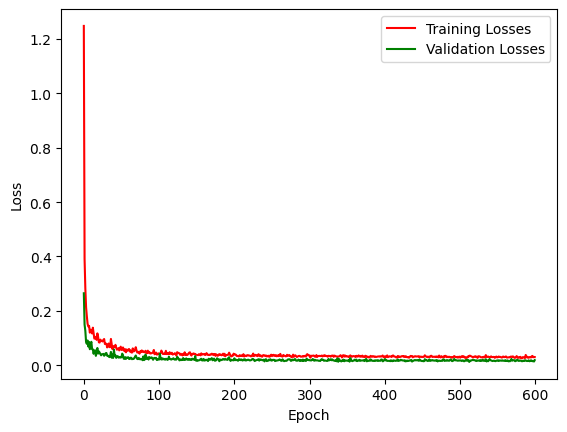

In [12]:
# Baseline
run_name = "1"
train(run_name)